# CLIP-DINOiser visualization demo 🖼️

In [ ]:
from hydra.core.global_hydra import GlobalHydra
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np
from operator import itemgetter 
import torch
import warnings
warnings.filterwarnings('ignore')
GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)


In [18]:
def visualize_per_image(file_path, text_prompts, palette, model):
    assert os.path.isfile(file_path), f"No such file: {file_path}"

    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    h, w = img_tens.shape[-2:]
    output = model(img_tens).cpu()
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
    output = output[0].argmax(dim=0)
    mask = mask2rgb(output, palette)

    fig = plt.figure(figsize=(3, 1))
    classes = np.unique(output).tolist()
    plt.imshow(np.array(itemgetter(*classes)(PALETTE)).reshape(1, -1, 3))
    plt.xticks(np.arange(len(classes)), list(itemgetter(*classes)(text_prompts)), rotation=45)
    plt.yticks([])

    return mask, fig, img

### Load and configure a model

In [ ]:
check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates=False # switching off the imagenet templates for fast inference
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()

### Example with 'background' class

(-0.5, 563.5, 381.5, -0.5)

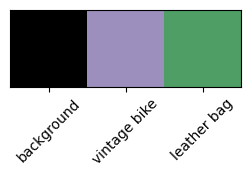

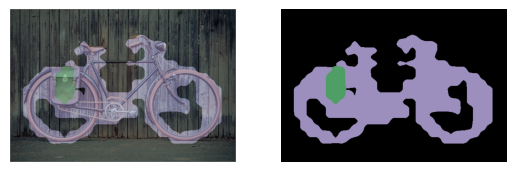

In [20]:
file = 'assets/vintage_bike.jpeg'
PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]

# specify your prompts
TEXT_PROMPTS = ['background', 'vintage bike', 'leather bag']
model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
model.to(device)

# set apply FOUND (background detector) to True
model.apply_found = True

# run segmentation
mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)

fig, ax = plt.subplots(nrows=1, ncols=2)
alpha=0.5
blend = (alpha)*np.array(img)/255. + (1-alpha) * mask/255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

### Example without 'background' class

(-0.5, 1449.5, 793.5, -0.5)

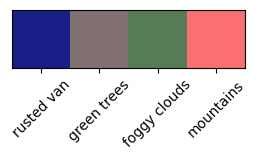

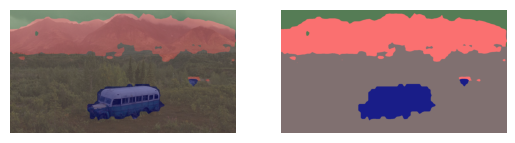

In [21]:
file = 'assets/rusted_van.png'

PALETTE = [[25, 29, 136], [128, 112, 112], [85, 124, 85], [250, 112, 112], [250, 250, 0], [250, 0, 0]]

# specify TEXT PROMPTS
TEXT_PROMPTS = ["rusted van", "green trees", "foggy clouds", "mountains"] 
model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
model.to(device)

# specify whether applying FOUND or not
model.apply_found = False
mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)

fig, ax = plt.subplots(nrows=1, ncols=2)
alpha=0.5
blend = (alpha)*np.array(img)/255. + (1-alpha)*mask/255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')
